# Potential sites of chemical modification

An initial scan of the antibody sequences is presented based purely upon sequence. If a structural analysis was also requested, this section should be used in conjunction with the molecular surface analysis described in a subsequent section. Any of the sites listed below could be candidates for further consideration if the molecular surface analysis shows that they are significantly exposed on the surface of the antibody, increasing their propensity for chemical modification. The canonical sequence analysis is also helpful here, since each of these sites can also be considered in the context of their frequency of occurrence within the canonical library of homologous sequences.

This is an example of a footnote.[^footnote1]

[^footnote1]: The definition for referencing footnotes is generally placed at the bottom of the document.


In [1]:
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils.ProtParam import ProtParamData
import re

record = SeqIO.read("../data/sequence.fasta", "fasta")
my_seq = str(record.seq)
analyzed_seq = ProteinAnalysis(my_seq)
target_name = record.name

## Potential deamidation positions

Asparagine (N) and glutamine (Q) residues are particularly prone to deamidation when they are followed in the sequence by amino acids with smaller side chains, that leave the intervening peptide group more exposed. Deamidation proceeds much more quickly if the susceptible amino acid is followed by a small, flexible residue such as glycine whose low steric hindrance leaves the peptide group open for attack.

### Search patterns: ASN/GLN-ALA/GLY/SER/THR

In [2]:

deamidation_pattern = '(N|Q)(A|G|S|T)'

match = re.finditer(deamidation_pattern, my_seq)    

if re.search(deamidation_pattern, my_seq):
    for i in match:
        print(f'{i.start()+1}-{i.group()}-{i.end()}')
else:
    print('There is no deamination pattern found.')

68-NA-69
84-NG-85
97-QT-98
99-NT-100
158-QS-159
180-QG-181
196-NS-197
271-NA-272
282-NS-283
300-NG-301
369-NG-370
404-QG-405


## Potential o-linked glycosylation sites

The O-linked glycosylation of serine and threonine residues seems to be particularly sensitive to
the presence of one or more proline residues in their vicinity in the sequence, particularly in the2
-1 and +3 positions.

### Search patterns: PRO-SER/THR


In [3]:
o_glycosylation_pattern = 'P(S|T)'

match = re.finditer(o_glycosylation_pattern, my_seq)    

if re.search(o_glycosylation_pattern, my_seq):
    for i in match:
        print(f'{i.start()+1}-{i.group()}-{i.end()}')
else:
    print('There is no pattern found.')

108-PS-109
141-PS-142
223-PS-224
338-PS-339
359-PS-360


### Search patterns: SER/THR-X-X-PRO

In [4]:
o_glycosylation_pattern = '(S|T)[A-Z]{2}P'

match = re.finditer(o_glycosylation_pattern, my_seq)    

if re.search(o_glycosylation_pattern, my_seq):
    for i in match:
        print(f'{i.start()+1}-{i.group()}-{i.end()}')
else:
    print('There is no pattern found.')

3-TGRP-6
12-SEIP-15
48-TLIP-51
210-TCPP-213
239-SRTP-242
335-TLPP-338
378-TTPP-381
427-SLSP-430


## Potential n-linked glycosylation sites

### Search patterns: ASN-X-SER/THR

In [5]:
N_glycosylation_pattern = 'N[A-Z][S|T]'
# N_glycosylation_pattern = 'N[^P][ST][^P]'
# putting a caret ^ at the start of the group will negate it
# and match any character that is not in that group
match = re.finditer(N_glycosylation_pattern, my_seq) 

if re.search(N_glycosylation_pattern, my_seq):
    for i in match:
        print(f'{i.start()+1}-{i.group()}-{i.end()}')
else:
    print("There is no pattern found.")

36-NIT-38
68-NAT-70
123-NCT-125
196-NST-198
282-NST-284


## Secondary structure fraction

A very useful method — .secondary_structure_fraction() — returns the fraction of amino acids that tend to be found in the three classical secondary structures. These are beta sheets, alpha helixes, and turns (where the residues change direction).

Secondary_structure_fraction: This methods returns a list of the fraction of amino acids which tend to be in helix, turn or sheet.

  + Amino acids in helix: V, I, Y, F, W, L.
  + Amino acids in turn: N, P, G, S.
  + Amino acids in sheet: E, M, A, L.


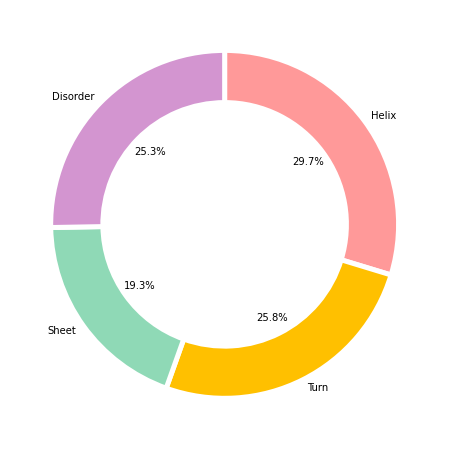

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))

data = analyzed_seq.secondary_structure_fraction()
rest = (1-sum(analyzed_seq.secondary_structure_fraction()),)
names = ['Helix','Turn','Sheet','Disorder']
values = analyzed_seq.secondary_structure_fraction() + rest
colors = ['#ff9999', '#ffc000', '#8fd9b6', '#d395d0']
# colors = ['#ECD078', '#D95B43', '#C02942', '#542437', '#53777A'] #Thought Provoking
wedgeprops={'width': 0.3, 'edgecolor': 'w', 'linewidth': 5}

plt.pie(values, labels=names, autopct='%.1f%%', startangle=90, labeldistance=1.05,
        counterclock=False, colors=colors, wedgeprops=wedgeprops)
plt.show()

## Secondary structure prediction

Protein secondary structure prediction is one of the most important and challenging problems in bioinformatics. Here in, the P-SEA algorithm that to predict the secondary structures of proteins sequences based only on knowledge of their primary structure.

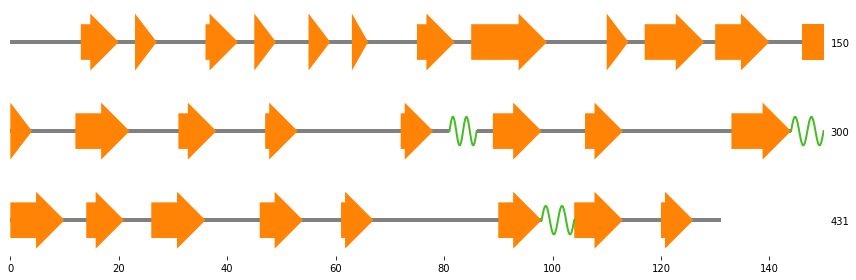

In [7]:
# Code source: Patrick Kunzmann
# License: BSD 3 clause

from tempfile import gettempdir
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import biotite
import biotite.structure as struc
import biotite.structure.io.mmtf as mmtf
import biotite.sequence as seq
import biotite.sequence.graphics as graphics
import biotite.sequence.io.genbank as gb
import biotite.database.rcsb as rcsb
import biotite.database.entrez as entrez
import biotite.application.dssp as dssp
import biotite.structure.io.pdb as pdb

# Create 'FeaturePlotter' subclasses
# for drawing the scondary structure features

class HelixPlotter(graphics.FeaturePlotter):

    def __init__(self):
        pass

    # Check whether this class is applicable for drawing a feature
    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "helix":
                    return True
        return False

    # The drawing function itself
    def draw(self, axes, feature, bbox, loc, style_param):
        # Approx. 1 turn per 3.6 residues to resemble natural helix
        n_turns = np.ceil((loc.last - loc.first + 1) / 3.6)
        x_val = np.linspace(0, n_turns * 2*np.pi, 100)
        # Curve ranges from 0.3 to 0.7
        y_val = (-0.4*np.sin(x_val) + 1) / 2

        # Transform values for correct location in feature map
        x_val *= bbox.width / (n_turns * 2*np.pi)
        x_val += bbox.x0
        y_val *= bbox.height
        y_val += bbox.y0

        # Draw white background to overlay the guiding line
        background = Rectangle(
            bbox.p0, bbox.width, bbox.height, color="white", linewidth=0
        )
        axes.add_patch(background)
        axes.plot(
            x_val, y_val, linewidth=2, color=biotite.colors["dimgreen"]
        )


class SheetPlotter(graphics.FeaturePlotter):

    def __init__(self, head_width=0.8, tail_width=0.5):
        self._head_width = head_width
        self._tail_width = tail_width


    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "sheet":
                    return True
        return False

    def draw(self, axes, feature, bbox, loc, style_param):
        x = bbox.x0
        y = bbox.y0 + bbox.height/2
        dx = bbox.width
        dy = 0

        if  loc.defect & seq.Location.Defect.MISS_RIGHT:
            # If the feature extends into the prevoius or next line
            # do not draw an arrow head
            draw_head = False
        else:
            draw_head = True

        axes.add_patch(biotite.AdaptiveFancyArrow(
            x, y, dx, dy,
            self._tail_width*bbox.height, self._head_width*bbox.height,
            # Create head with 90 degrees tip
            # -> head width/length ratio = 1/2
            head_ratio=0.5, draw_head=draw_head,
            color=biotite.colors["orange"], linewidth=0
        ))
# Helper function to convert secondary structure array to annotation
# and visualize it
def visualize_secondary_structure(sse, first_id):

    def _add_sec_str(annotation, first, last, str_type):
        if str_type == "a":
            str_type = "helix"
        elif str_type == "b":
            str_type = "sheet"
        else:
            # coil
            return
        feature = seq.Feature(
            "SecStr", [seq.Location(first, last)], {"sec_str_type" : str_type}
        )
        annotation.add_feature(feature)

    # Find the intervals for each secondary structure element
    # and add to annotation
    annotation = seq.Annotation()
    curr_sse = None
    curr_start = None
    for i in range(len(sse)):
        if curr_start is None:
            curr_start = i
            curr_sse = sse[i]
        else:
            if sse[i] != sse[i-1]:
                _add_sec_str(
                    annotation, curr_start+first_id, i-1+first_id, curr_sse
                )
                curr_start = i
                curr_sse = sse[i]
    # Add last secondary structure element to annotation
    _add_sec_str(annotation, curr_start+first_id, i-1+first_id, curr_sse)

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(111)
    graphics.plot_feature_map(
        ax, annotation, symbols_per_line=150,
        loc_range=(first_id, first_id+len(sse)),
        show_numbers=True, show_line_position=True,
        feature_plotters=[HelixPlotter(), SheetPlotter()]
    )
    fig.tight_layout()
    
# Fetch and load structure
pdb_file = pdb.PDBFile.read("../data/structure.pdb")
array = pdb_file.get_structure(model=1)
# Transketolase homodimer
tk_dimer = array[struc.filter_amino_acids(array)]
# Transketolase monomer
tk_mono = tk_dimer[tk_dimer.chain_id == "A"]


sse = struc.annotate_sse(array, chain_id="A")
visualize_secondary_structure(sse, tk_mono.res_id[0])

plt.show()

## Protein Scales

Protein scales are a way of measuring certain attributes of residues over the length of the peptide sequence using a sliding window. Scales are comprised of values for each amino acid based on different physical and chemical properties, such as hydrophobicity, secondary structure tendencies, and surface accessibility. As opposed to some chain-level measures like overall molecule behavior, scales allow a more granular understanding of how smaller sections of the sequence will behave.

Some common scales include:

    - kd → Kyte & Doolittle Index of Hydrophobicity
    - Flex → Normalized average flexibility parameters (B-values)
    - hw → Hopp & Wood Index of Hydrophilicity
    - em → Emini Surface fractional probability (Surface Accessibility)
 
 
### Hydrophobicity index

hydrophobicity is the physical property of a molecule that is seemingly repelled from a mass of water (known as a hydrophobe).

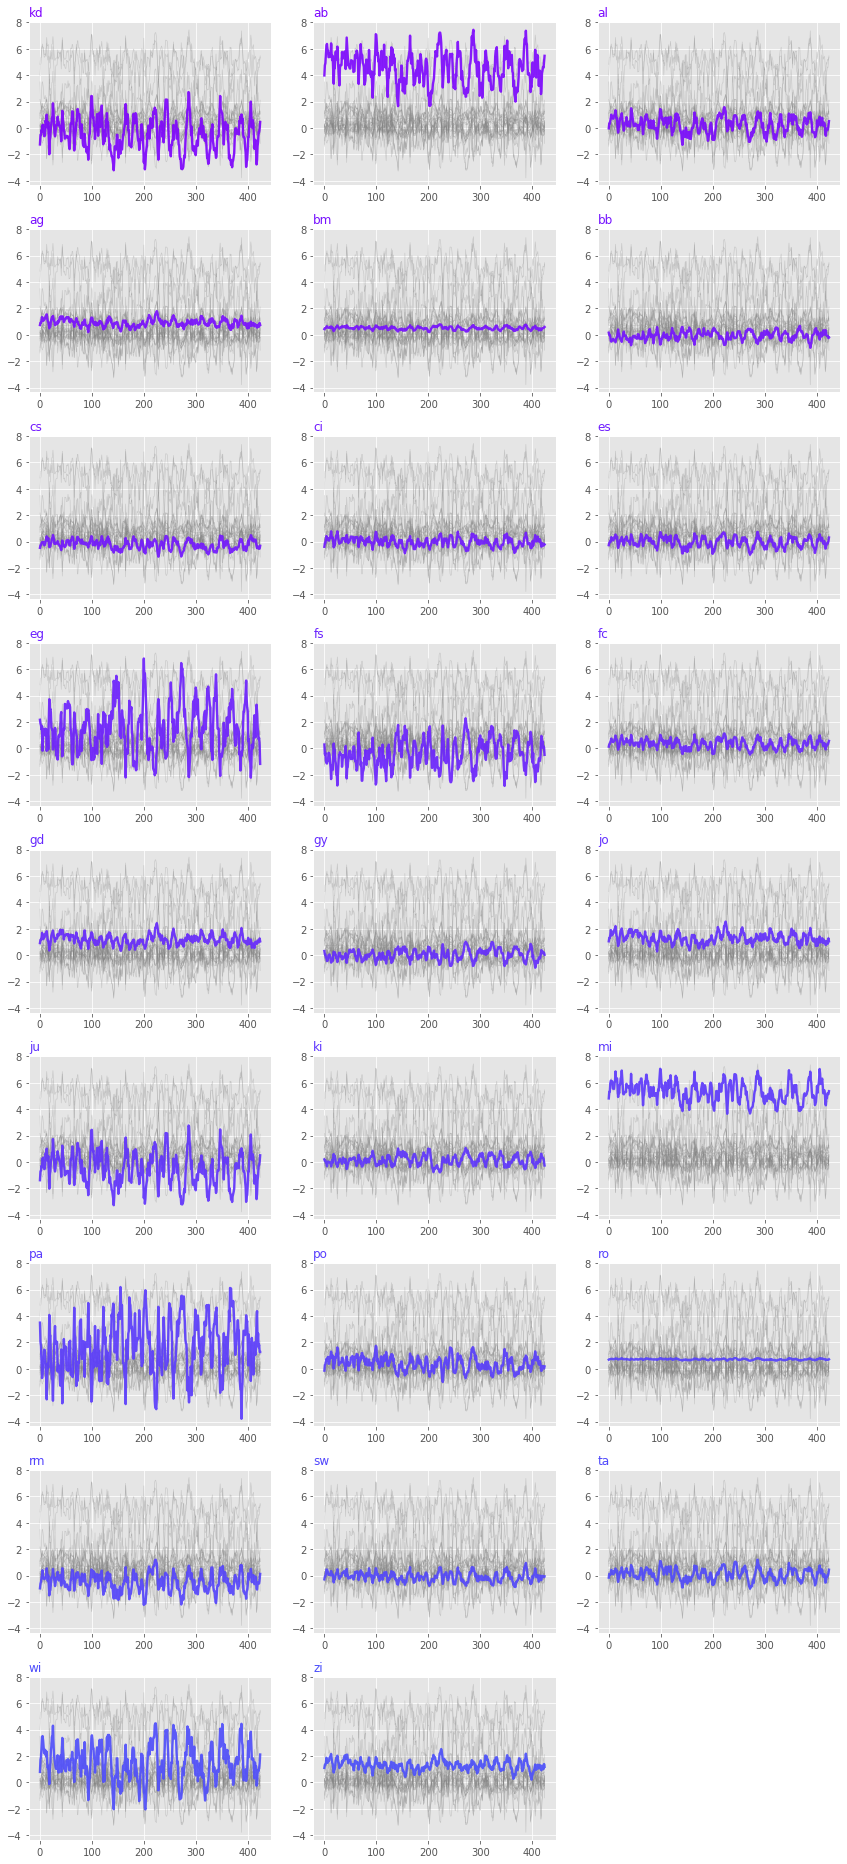

In [8]:
# plt.figure(figsize=(15,6))
# plt.style.use('ggplot')

# gravy_scales = ['kd','ab','al','ag','bm','bb','cs','ci','es','eg','fs','fc','gd']

# for i in gravy_scales:
#     method_to_call = getattr(ProtParamData, i)
#     data = analyzed_seq.protein_scale(window=7, param_dict=method_to_call)
#     plt.plot(data, label=i, alpha=0.7)

# plt.title('Hydrophobicity(1)')
# plt.xlabel('Position')
# plt.ylabel('')
# plt.legend()
# plt.show()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

gravy_scales = ['kd','ab','al','ag','bm','bb','cs','ci','es','eg','fs','fc','gd',
               'gy','jo','ju','ki', 'mi', 'pa','po','ro','rm','sw','ta','wi','zi']
df = pd.DataFrame()

for i in gravy_scales:
    method_to_call = getattr(ProtParamData, i)
    df[i] = analyzed_seq.protein_scale(window=7, param_dict=method_to_call)

plt.figure(figsize=(12,26))
plt.style.use('ggplot')

# create a color palette
palette = plt.get_cmap('rainbow')

# multiple line plot
num=0
for column in df.columns:
    num+=1
    # Find the right spot on the plot
    plt.subplot(9,3, num)
 
    # plot every group, but discrete
    for v in df.columns:
        plt.plot(df[v], marker='', color='grey', linewidth=0.6, alpha=0.3)
 
    # Plot the lineplot
    plt.plot(df[column], marker='', color=palette(num), linewidth=2.4, alpha=0.9, label=column)
 
    # Add title
    plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num))

plt.tight_layout()
plt.show()

### Hydrophilicity index

Hydrophilicity is the tendency of a molecule to be solvated by water. 

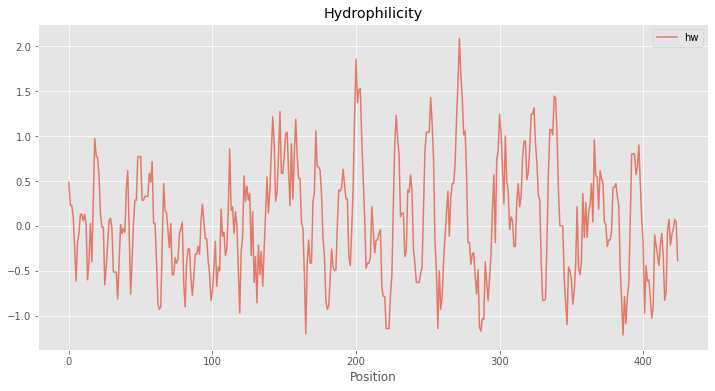

In [9]:
plt.figure(figsize=(12,6))
plt.style.use('ggplot')
_list = ['hw']

for i in _list:
    method_to_call = getattr(ProtParamData, i)
    data = analyzed_seq.protein_scale(window=7, param_dict=method_to_call)
    plt.plot(data, label=i, alpha=0.7)

plt.title('Hydrophilicity')
plt.xlabel('Position')
plt.ylabel('')
plt.legend()
plt.show()

### Flexibility index

Proteins are dynamic entities, and they possess an inherent flexibility that allows them to function through molecular interactions within the cell.

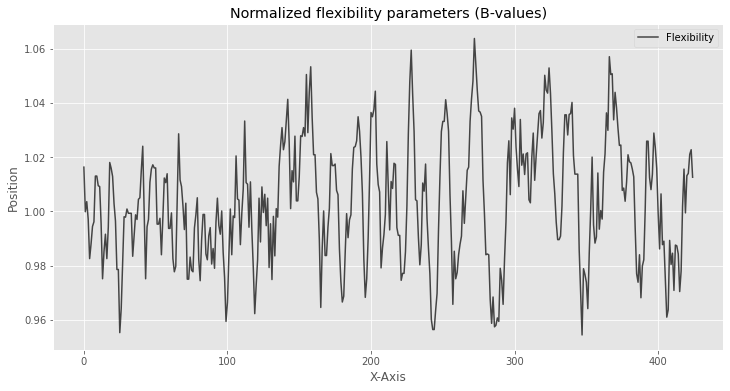

In [10]:
plt.figure(figsize=(12,6))
plt.style.use('ggplot')


data = analyzed_seq.protein_scale(window=7, param_dict=ProtParamData.Flex)
plt.plot(data, label='Flexibility', color='k', alpha=0.7)

plt.title('Normalized flexibility parameters (B-values)') # average
plt.xlabel('X-Axis')
plt.ylabel('Position')
plt.legend()
plt.show()

### Surface accessibility

Data describing the solvent-accessible surface of a molecule is of great utility in the
development of that molecule as a therapeutic, particularly in the case of antibodies. In the
context of this report, the most obvious application of molecular surface data is in combination
with the potential sites of chemical modification, described in the previous section. Antibodies
(and other proteins) are known to undergo many different chemical modifications as a result of
interactions with their aqueous environment. The probability and kinetic rate of such a
modification is greatly enhanced by the degree of exposure of the potential modification site to
the solvent environment.
If a 3D structure was supplied or requested by the client, then the graphs below will show the
solvent-accessible surface areas in (Å2) calculated for each residue in the light and heavy chain
variable regions of the antibody. These solvent-accessible surfaces are calculated using the
“rolling ball” algorithm developed by Shrake & Rupley in which a spherical solvent “probe” is3
used, the accessible surface being generated by tracing the center of the probe sphere as it
rolls along the van der Waals surface (as shown below).

![](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Accessible_surface.svg/280px-Accessible_surface.svg.png)

<p align="center">
    Image by Keith Callenberg - courtesy of Wikimedia Common
</p>

The solvent-accessible surface for each residue depends upon the degree of exposure of the
residue on the antibody surface, but also on the size of the residue side chain. Residues that
are completely buried within the hydrophobic core of the antibody, will have solvent-accessible
surface areas at or close to zero. Residues that are highly exposed at the antibody surface will
have values that range from around 100 - 200 Å2, depending upon the size of the residue side
chain and the degree of exposure.

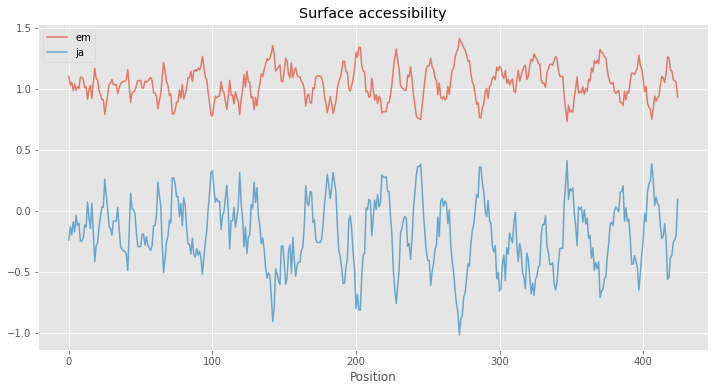

In [11]:
# Surface accessibility
# Vergoten G & Theophanides T, Biomolecular Structure and Dynamics,
# pg.138 (1997).
# 1 Emini Surface fractional probability
# 2 Janin Interior to surface transfer energy scale

plt.figure(figsize=(12,6))
plt.style.use('ggplot')

_list = ['em','ja']

for i in _list:
    method_to_call = getattr(ProtParamData, i)
    data = analyzed_seq.protein_scale(window=7, param_dict=method_to_call)
    plt.plot(data, label=i, alpha=0.7)

plt.title('Surface accessibility')
plt.xlabel('Position')
plt.ylabel('')
plt.legend()
plt.show()

### Instability index

The instability index provides an estimate of the stability of your protein in a test tube. Statistical analysis of 12 unstable and 32 stable proteins has revealed that there are certain dipeptides, the occurence of which is significantly different in the unstable proteins compared with those in the stable ones.

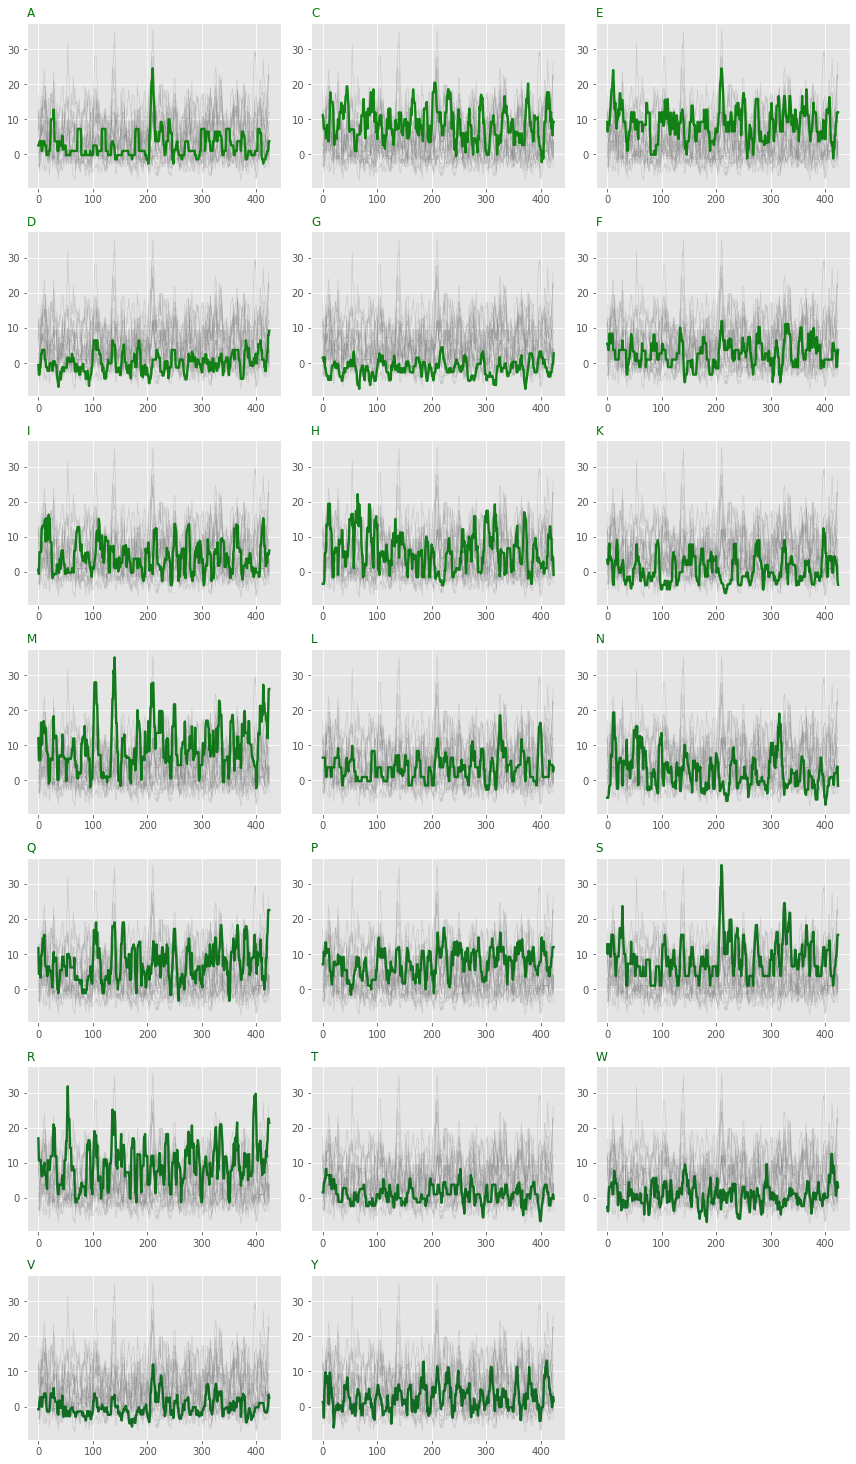

In [12]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

_list = list('ACEDGFIHKMLNQPSRTWVY')
df = pd.DataFrame()

for i in _list:
    df[i] = analyzed_seq.protein_scale(window=7, param_dict=ProtParamData.DIWV[i])

plt.figure(figsize=(12,26))
plt.style.use('ggplot')

# create a color palette
palette = plt.get_cmap('ocean')

# multiple line plot
num=0
for column in df.columns:
    num+=1
    # Find the right spot on the plot
    plt.subplot(9,3, num)
 
    # plot every group, but discrete
    for v in df.columns:
        plt.plot(df[v], marker='', color='grey', linewidth=0.6, alpha=0.3)
 
    # Plot the lineplot
    plt.plot(df[column], marker='', color=palette(num), linewidth=2.4, alpha=0.9, label=column)
 
    # Add title
    plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num))

plt.tight_layout()
plt.show()